In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# fastext
from gensim.models import FastText

from tabulate import tabulate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Data exploration & pre-processing
data = pd.read_json('/content/gdrive/MyDrive/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# shape of the dataset
print(data.shape)
# total number of unique categories
print("Unique categories:",data['category'].nunique())
print("-------------------------------------------------")
# information about metadata
data.info()

(200853, 6)
Unique categories: 41
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [ ]:
# general descrption of dataset
data.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelikeu.com/closets/megan-lecrone/,,2013-04-24 00:00:00
freq,32739,90,36620,2,19712,100
first,nan,nan,nan,nan,nan,2012-01-28 00:00:00
last,nan,nan,nan,nan,nan,2018-05-26 00:00:00


1. Dataset has 41 distinct categories of news articles.
2. 'Politics' is the most common category of news in the dataset.
3. There are 27993 unique authors who have written news articles.

In [ ]:
# drop columns like authors, links and date as they are irrelevent to the problem.
new_data = data.drop(columns=['authors','link','date'])
new_data.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


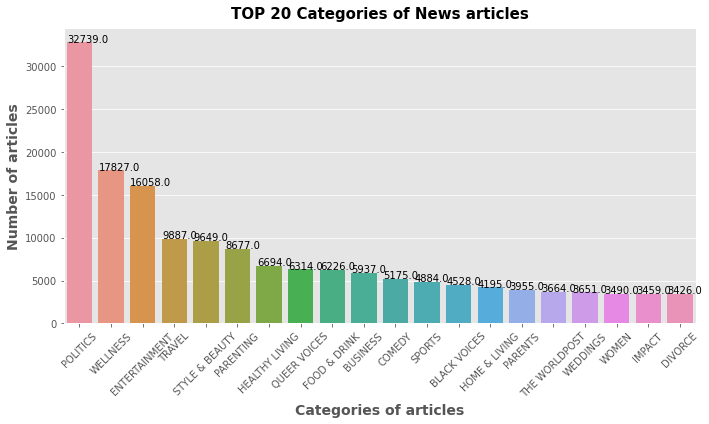

In [ ]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_data['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

# Visualize top 20 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df.news_classes)[:20], np.array(cat_df.numcat)[:20])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 20 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

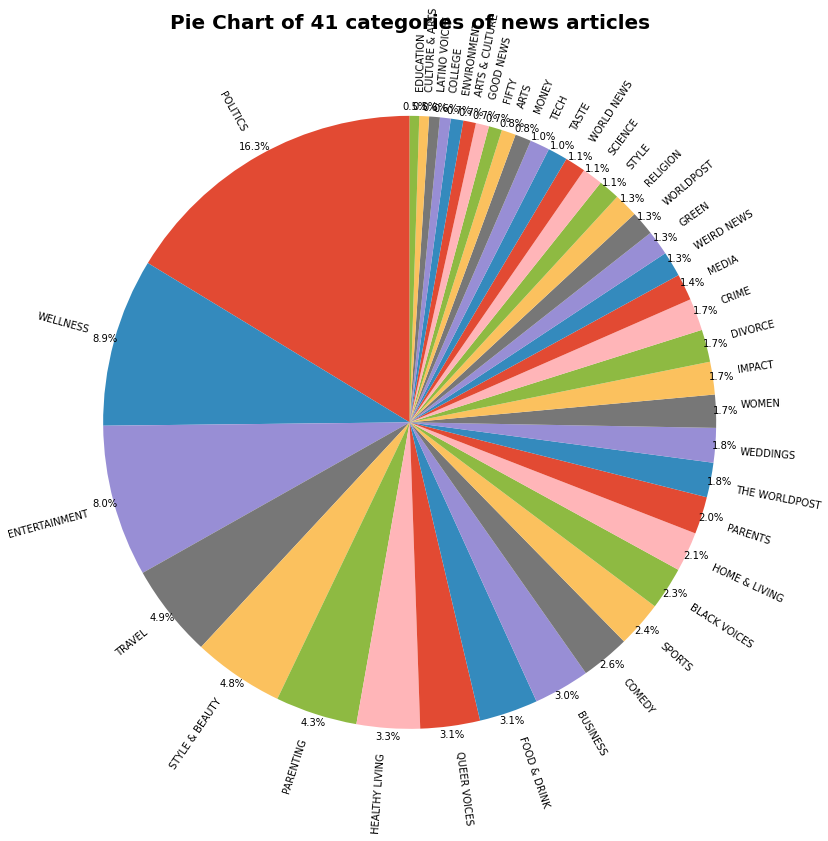

In [ ]:
# plot the pie chart of 41 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:41],
            labels=cat_df['news_classes'][:41],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of 41 categories of news articles", size=20, weight='bold')
plt.show()

In [ ]:
new_data=new_data[new_data.category.isin(['BUSINESS', 'ENTERTAINMENT','POLITICS','SPORTS','TECH'])]

We will only use 5 categories news among 41 unique categories:
1. business: 5937 (3.0%)
2. entertainment: 16058 (8.0%)
3. politics: 32739 (16.3%)
4. sports: 4884 (2.4%)
5. tech: 2082 (1.0%)

In [ ]:
# create final dataframe of combined headline and short_description
final_data = new_data.copy()
final_data['length_of_news'] = final_data['headline'] + final_data['short_description']
final_data.drop(['headline','short_description'], inplace=True, axis=1)
final_data['len_news'] = final_data['length_of_news'].map(lambda x: len(x))
final_data.head()

,category,length_of_news,len_news
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,99
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,134
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,155
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,158
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,205


In [ ]:
# maximum length of news in each category
lenmax_df = final_data.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
2,POLITICS,1486
0,BUSINESS,950
1,ENTERTAINMENT,541
4,TECH,483
3,SPORTS,462


In [ ]:
# minimum lenght of news in each category
lenmin_df = final_data.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
4,TECH,17
1,ENTERTAINMENT,6
3,SPORTS,3
0,BUSINESS,0
2,POLITICS,0


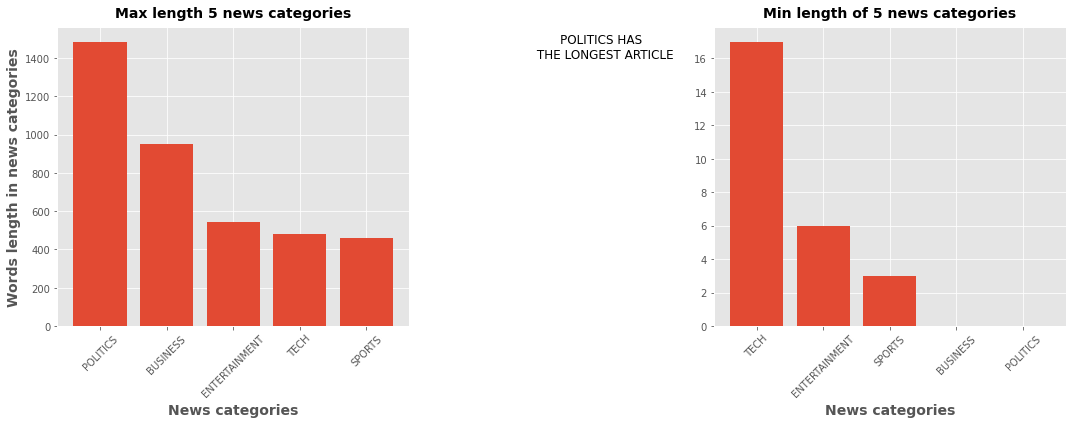

In [ ]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:5],lenmax_df['len_news'][:5])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length 5 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:5], lenmin_df['len_news'][:5])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of 5 news categories", size=14)

plt.show()

1. POLITICS has the most number of articles as well as length of characters in the article.
2. After 'POLITICS' category, 'BUSINESS' and 'ENTERTAINMENT' are in top 3 most length of articles.
3. 'POLITICS', 'BUSINESS' and 'ENTERTAINMENT' are top 3 categories having most number of articles in the dataset.

(-0.5, 1599.5, 599.5, -0.5)

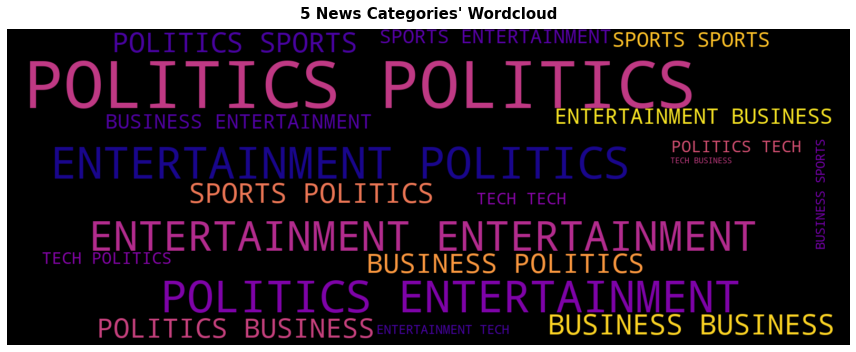

In [ ]:
# wordcloud of categories of news articles in the dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_data.category))

plt.title("5 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

In [ ]:
ndf = final_data.copy()
ndf.drop('len_news', inplace=True, axis=1)
print(ndf)

             category                                     length_of_news
1       ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...
2       ENTERTAINMENT  Hugh Grant Marries For The First Time At Age 5...
3       ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4       ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...
5       ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...
...               ...                                                ...
200848           TECH  RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849         SPORTS  Maria Sharapova Stunned By Victoria Azarenka I...
200850         SPORTS  Giants Over Patriots, Jets Over Colts Among  M...
200851         SPORTS  Aldon Smith Arrested: 49ers Linebacker Busted ...
200852         SPORTS  Dwight Howard Rips Teammates After Magic Loss ...

[61700 rows x 2 columns]


In [ ]:
#Counting by Subjects 
for key,count in ndf.category.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{ndf.shape[0]}")

POLITICS:	32739
ENTERTAINMENT:	16058
BUSINESS:	5937
SPORTS:	4884
TECH:	2082
Total Records:	61700


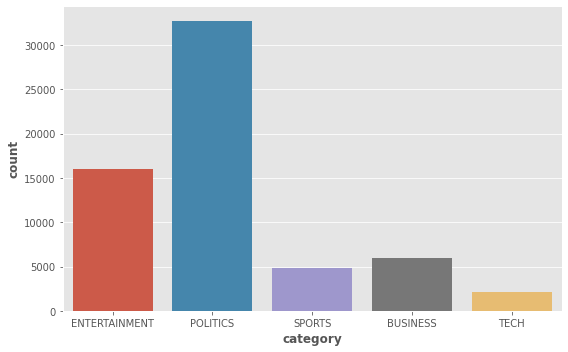

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot("category", data=ndf)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


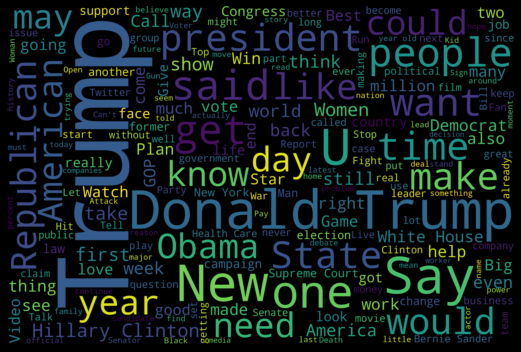

In [ ]:
#Word Cloud
import nltk
nltk.download('stopwords')
length_of_news = ''
for news in ndf.length_of_news.values:
    length_of_news += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(length_of_news)
fig = plt.figure(
    figsize = (8, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del length_of_news

In [ ]:
import nltk
nltk.download('punkt')
y = ndf["category"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in ndf["length_of_news"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del ndf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import gensim

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by FastText Method
w2v_model = gensim.models.FastText(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
w2v_model.save('fasttext_trained_model')

In [ ]:
fasttext_model = gensim.models.FastText.load('fasttext_trained_model')

In [ ]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later

ft_weights = fasttext_model.wv.vectors

In [ ]:
vocab_size, embedding_size = ft_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 75863 - Embedding Dim: 100


In [ ]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 75863 words by a 100dim vector.

75863

In [ ]:
#sample vector for random word, lets say people 
fasttext_model["people"]

array([-2.2454375e-01, -7.3772800e-01,  2.0064447e+00, -8.3010465e-01,
        2.0011981e+00,  1.3933933e+00, -4.5262918e-01,  1.6511660e+00,
        4.6840596e-01,  4.5854306e-01, -8.5014343e-02,  7.1795177e-01,
        9.7663069e-01, -4.3292832e-01,  8.7379855e-01,  3.2358941e-01,
        4.3012136e-01,  1.2073951e+00, -3.6609292e-01, -4.2474788e-02,
       -8.5455745e-01,  6.2973124e-01,  2.3778789e+00, -1.2391539e+00,
        5.8337831e-01,  1.8231368e+00, -8.1744128e-01, -1.8242939e+00,
        1.8786796e+00, -3.2995602e-01, -4.7425571e-01,  6.5474266e-01,
        5.1782501e-01,  4.1489232e-01, -1.2257189e+00,  5.6341612e-01,
        6.4788705e-01, -1.6679137e+00, -6.7891496e-01, -2.0012195e+00,
        1.0812187e+00,  7.4773937e-01,  4.1324306e-01, -2.1773090e+00,
        3.1877971e-01, -5.2482504e-01, -9.6062773e-01, -1.2524705e+00,
       -6.1834919e-01, -2.1252739e-01, -8.1000459e-01, -5.4083896e-01,
        5.3237468e-01, -6.1424226e-02,  7.8820658e-01,  1.0097449e+00,
      

In [ ]:
fasttext_model.wv.most_similar("america")

[('21america', 0.9977525472640991),
 ('americawhy', 0.9976076483726501),
 ('americaaaa', 0.9976028203964233),
 ('americaif', 0.9973768591880798),
 ('americai', 0.9973363280296326),
 ('americaat', 0.9973204135894775),
 ('americau', 0.9972609281539917),
 ('americaam', 0.9972425103187561),
 ('americaok', 0.9972203969955444),
 ('americawe', 0.9967010021209717)]

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# Check the first 10 words of first news
# Every word has been represented with a number
X[0][:10]

[773, 1539, 11274, 13221, 4691, 1219, 24, 1085, 421, 30616]

In [ ]:
#Check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break  

trump -> 1
new -> 2
donald -> 3
one -> 4
president -> 5
says -> 6
said -> 7
people -> 8
time -> 9
clinton -> 10


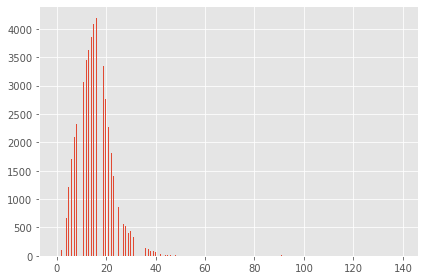

In [ ]:
# For determining size of input

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 60 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed

In [ ]:
nos = np.array([len(x) for x in X])
#len(nos)
len(nos[nos  < 60])
# Out of 61700 news, 61574 have less than 60 words

61574

In [ ]:
#Lets keep all news to 60, add padding to news with less than 60 words and truncating long ones
maxlen = 60 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
#all news has 60 words (in numerical form now). If they had less words, they have been padded with 0
len(X[0])

60

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from fasttext and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(fasttext_model, word_index)

In [ ]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen,trainable=False))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           7586400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 128)          21120     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 60, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [ ]:
X_train.shape

(46275, 60)

In [ ]:
X_test.shape

(15425, 60)

In [ ]:
y_train.shape

(46275, 5)

In [ ]:
y_test.shape

(15425, 5)

In [ ]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(X_train, y_train, 
                   batch_size=128, 
                    epochs=15, 
                    validation_split=0.2
                   )

# evalute the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
290/290 [==============================] - 76s 239ms/step - loss: 0.9862 - accuracy: 0.6662 - val_loss: 0.9262 - val_accuracy: 0.6464
Epoch 2/15
290/290 [==============================] - 70s 241ms/step - loss: 0.8615 - accuracy: 0.7036 - val_loss: 0.7864 - val_accuracy: 0.7297
Epoch 3/15
290/290 [==============================] - 70s 241ms/step - loss: 0.8251 - accuracy: 0.7153 - val_loss: 0.7999 - val_accuracy: 0.7286
Epoch 4/15
290/290 [==============================] - 68s 235ms/step - loss: 0.7992 - accuracy: 0.7210 - val_loss: 0.7494 - val_accuracy: 0.7356
Epoch 5/15
290/290 [==============================] - 68s 234ms/step - loss: 0.7824 - accuracy: 0.7270 - val_loss: 0.7137 - val_accuracy: 0.7452
Epoch 6/15
290/290 [==============================] - 68s 235ms/step - loss: 0.7774 - accuracy: 0.7283 - val_loss: 0.7161 - val_accuracy: 0.7453
Epoch 7/15
290/290 [==============================] - 68s 235ms/step - loss: 0.7637 - accuracy: 0.7320 - val_loss: 0.7981 - val_ac

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen,trainable=False))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(76, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           7586400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 60, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 60, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 58, 76)            29260     
                                                      

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(X_train, y_train, 
                     batch_size=128, 
                     epochs=15, 
                     validation_split=0.2,
                     shuffle=True
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(X_test, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15
290/290 [==============================] - 319s 1s/step - loss: 1.8740 - accuracy: 0.7233 - val_loss: 0.8152 - val_accuracy: 0.7533
Epoch 2/15
290/290 [==============================] - 299s 1s/step - loss: 0.7400 - accuracy: 0.7547 - val_loss: 0.7224 - val_accuracy: 0.7525
Epoch 3/15
290/290 [==============================] - 303s 1s/step - loss: 0.6925 - accuracy: 0.7757 - val_loss: 0.7355 - val_accuracy: 0.7398
Epoch 4/15
290/290 [==============================] - 305s 1s/step - loss: 0.6578 - accuracy: 0.7865 - val_loss: 0.6763 - val_accuracy: 0.7919
Epoch 5/15
290/290 [==============================] - 302s 1s/step - loss: 0.6344 - accuracy: 0.7944 - val_loss: 0.6530 - val_accuracy: 0.7882
Epoch 6/15
290/290 [==============================] - 300s 1s/step - loss: 0.6122 - accuracy: 0.8031 - val_loss: 0.6208 - val_accuracy: 0.8118
Epoch 7/15
290/290 [==============================] - 296s 1s/step - loss: 0.5985 - accuracy: 0.8095 - val_loss: 0.6623 - val_accuracy: 0.7942

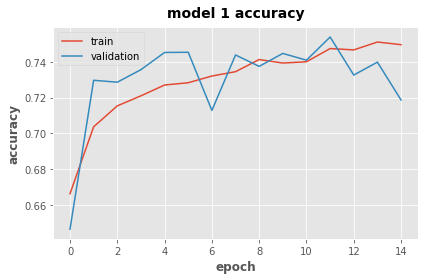

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

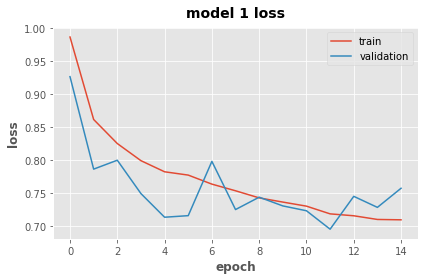

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[1067  247  164   11    2]
 [ 189 3461  243   24    5]
 [1109  725 6346   54    2]
 [  96 1002   75   93    0]
 [ 283  208   16    1    2]]


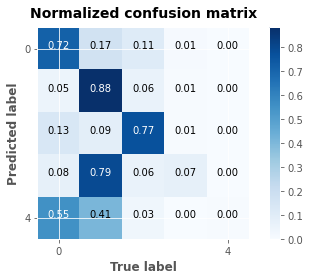

In [ ]:
#Evaluate model 1
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(X_test))
cm1 = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm1)

cm1 = cm1.astype('float') / cm1.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm1, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 4]); plt.yticks([0, 4])
plt.grid('off')
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
    plt.text(j, i, format(cm1[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm1[i, j] > 0.5 else 'black')

In [ ]:
total=sum(sum(cm1))
accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3]+cm1[4,4])/total
print ('Accuracy : ', accuracy)

sensitivity_business = cm1[0,0]/(cm1[0,0]+cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[4,0])
print('Sensitivity for business : ', sensitivity_business )

sensitivity_entertainment = cm1[1,1]/(cm1[1,1]+cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[4,1])
print('Sensitivity for entertainment : ', sensitivity_entertainment )

sensitivity_politics = cm1[2,2]/(cm1[2,2]+cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[4,2])
print('Sensitivity for politics : ', sensitivity_politics )

sensitivity_sports = cm1[3,3]/(cm1[3,3]+cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[4,3])
print('Sensitivity for sports : ', sensitivity_sports )

sensitivity_tech = cm1[4,4]/(cm1[4,4]+cm1[0,4]+cm1[1,4]+cm1[2,4]+cm1[3,4])
print('Sensitivity for tech : ', sensitivity_tech )

Accuracy :  0.4891971959092764
Sensitivity for business :  0.46797455030748875
Sensitivity for entertainment :  0.3778520225393201
Sensitivity for politics :  0.7458431488745029
Sensitivity for sports :  0.7694211046675936
Sensitivity for tech :  0.5783473179911244


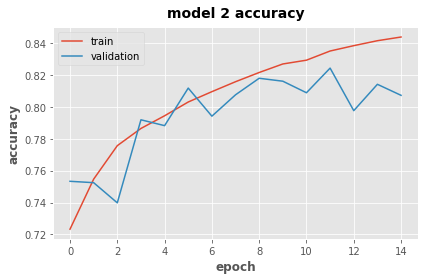

In [ ]:
plt.figure()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

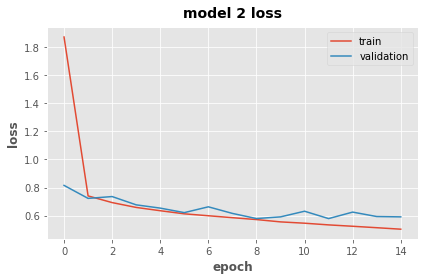

In [ ]:
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[1170  108  175   20   18]
 [ 200 3429  206   68   19]
 [ 687  457 7013   57   22]
 [ 130  430   76  626    4]
 [ 205   83   31    9  182]]


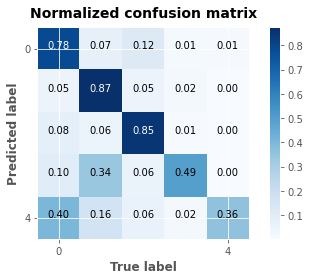

In [ ]:
#Evaluate model 2
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model2.predict(np.stack(X_test))
cm2 = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm2)

cm2 = cm2.astype('float') / cm2.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm2, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 4]); plt.yticks([0, 4])
plt.grid('off')
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
    plt.text(j, i, format(cm2[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm2[i, j] > 0.5 else 'black')

In [ ]:
total=sum(sum(cm2))
accuracy=(cm2[0,0]+cm2[1,1]+cm2[2,2]+cm2[3,3]+cm2[4,4])/total
print ('Accuracy : ', accuracy)

sensitivity_business = cm2[0,0]/(cm2[0,0]+cm2[1,0]+cm2[2,0]+cm2[3,0]+cm2[4,0])
print('Sensitivity for business : ', sensitivity_business )

sensitivity_entertainment = cm2[1,1]/(cm2[1,1]+cm2[0,1]+cm2[2,1]+cm2[3,1]+cm2[4,1])
print('Sensitivity for entertainment : ', sensitivity_entertainment )

sensitivity_politics = cm2[2,2]/(cm2[2,2]+cm2[0,2]+cm2[1,2]+cm2[3,2]+cm2[4,2])
print('Sensitivity for politics : ', sensitivity_politics )

sensitivity_sports = cm2[3,3]/(cm2[3,3]+cm2[0,3]+cm2[1,3]+cm2[2,3]+cm2[4,3])
print('Sensitivity for sports : ', sensitivity_sports )

sensitivity_tech = cm2[4,4]/(cm2[4,4]+cm2[0,4]+cm2[1,4]+cm2[2,4]+cm2[3,4])
print('Sensitivity for tech : ', sensitivity_tech )

Accuracy :  0.6723692362102429
Sensitivity for business :  0.551150766771834
Sensitivity for entertainment :  0.5810765244858079
Sensitivity for politics :  0.7454852071023212
Sensitivity for sports :  0.8993802267557776
Sensitivity for tech :  0.9400763025862738
